In [2]:
import torch
import numpy as np

In [3]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms


num_workers = 0

batch_size = 20


transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)


/Users/swayam/Desktop/deep-learning-v2-pytorch/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
validate_size = 0.2

In [6]:
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(validate_size * len(train_data))
train_idx, valid_idx = indicies[split:], indicies[:split]

In [7]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

/var/folders/_v/bhr29ckd759fkz4gv9xgp72w0000gn/T/ipykernel_7046/611598023.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


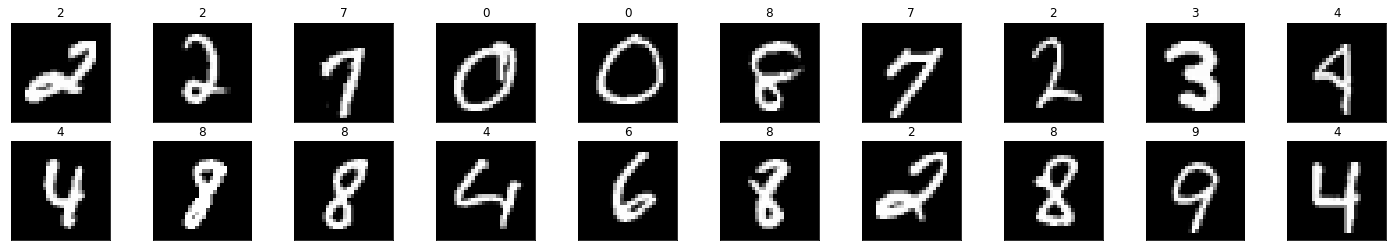

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

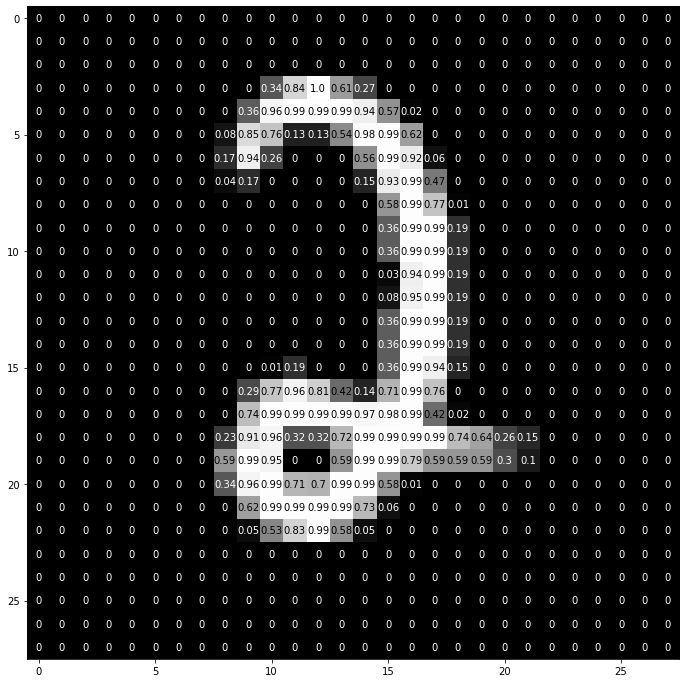

In [10]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
height, width = img.shape # arr.shape returns (row, col)
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[y][x],2) if img[y][x] !=0 else 0  # img[y][x] because img[row][col]
        ax.annotate(text=str(val), xy=(x,y),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[y][x]<thresh else 'black')

In [14]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:

from torch import optim

criterion = nn.CrossEntropyLoss() # log_softmax() + NLLLog() + mean


optimizer = optim.SGD(model.parameters(),lr=0.003)

In [16]:
valid_loss_min = np.inf
epochs = 40

for num in range(1,epochs+1):
    # training the data
    train_loss = 0
    valid_loss = 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validate model
    model.eval()
    with torch.inference_mode():
        for images, labels in valid_loader:
            output = model.forward(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        num, 
        train_loss,
        valid_loss
        ))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss




Epoch: 1 	Training Loss: 1.984526 	Validation Loss: 1.298493
Validation loss decreased (inf --> 1.298493).  Saving model ...
Epoch: 2 	Training Loss: 0.967241 	Validation Loss: 0.611337
Validation loss decreased (1.298493 --> 0.611337).  Saving model ...
Epoch: 3 	Training Loss: 0.638710 	Validation Loss: 0.466705
Validation loss decreased (0.611337 --> 0.466705).  Saving model ...
Epoch: 4 	Training Loss: 0.531107 	Validation Loss: 0.402093
Validation loss decreased (0.466705 --> 0.402093).  Saving model ...
Epoch: 5 	Training Loss: 0.467539 	Validation Loss: 0.359969
Validation loss decreased (0.402093 --> 0.359969).  Saving model ...
Epoch: 6 	Training Loss: 0.426722 	Validation Loss: 0.332182
Validation loss decreased (0.359969 --> 0.332182).  Saving model ...
Epoch: 7 	Training Loss: 0.392579 	Validation Loss: 0.312244
Validation loss decreased (0.332182 --> 0.312244).  Saving model ...
Epoch: 8 	Training Loss: 0.369966 	Validation Loss: 0.291645
Validation loss decreased (0.31224

In [17]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [22]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:

    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.101872

Test Accuracy of     0: 98% (967/980)
Test Accuracy of     1: 98% (1120/1135)
Test Accuracy of     2: 96% (1001/1032)
Test Accuracy of     3: 97% (982/1010)
Test Accuracy of     4: 96% (952/982)
Test Accuracy of     5: 95% (849/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 96% (989/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 95% (966/1009)

Test Accuracy (Overall): 96% (9694/10000)


/var/folders/_v/bhr29ckd759fkz4gv9xgp72w0000gn/T/ipykernel_5683/3186450429.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


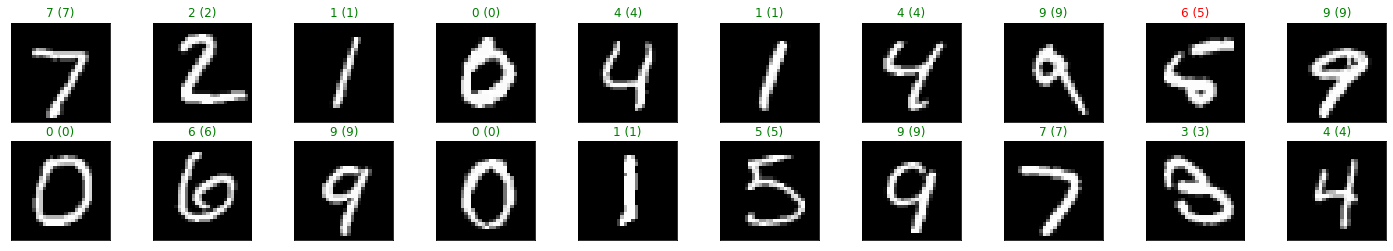

In [23]:

dataiter = iter(test_loader)
images, labels = dataiter.next()


output = model(images)

_, preds = torch.max(output, 1)

images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))